In [ ]:
#!pip install TextBlob

from textblob import TextBlob
import csv
import string
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import time
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize

# General note: All the individual snippets were designed to be run separately, and save all the progress at the end
# since some parts of the code took hours to run.

# This first snippet of codes saves a list of all the links to the news articles that appear on the first page of the
# archive section of the Chicago Suntimes website, for each date between Jan 1 and April 30. It also saves a list that 
# contains, for each article link, the date of the article in the MYSQL format.
 

url = 'https://chicago.suntimes.com/archives/2020/{0}/{1}'
date = '2020-{0}-{1}'
date_check = '2020/{0}/{1}'

days_in_month = [31,29,31,30]
links = []
dates = []
for month in tqdm(range(1,5)):
    for day in tqdm(range(days_in_month[month-1])):
        time.sleep(10)                                 # to prevent getting timed out
        res = requests.get(url.format(month, day))
        soup = BeautifulSoup(res.text)
        links_raw = ([a.get('href') for a in soup.find_all('a')])
        links_local = []
        for link in links_raw:
            try: 
                if date_check.format(month, day) in link:
                    links_local.append(link)
            except:
                pass
        links.extend(links_local)
        count = len(links_local)
        dates.extend([date.format(month, day)]*count)
links = list(links)


np.save('Chicago_Suntimes_links.npy', links)
np.save('Chicago_Suntimes_dates.npy', dates)

In [ ]:
# This snippet of code loads each article link, extracts the title and body, and saves them along with the date in a csv.

links = np.load('Chicago_Suntimes_links.npy')
dates = np.load('Chicago_Suntimes_dates.npy')

results = []
index = 0
for page in tqdm(links):
    time.sleep(8)  # to prevent the newspaper page from timing me out due to too many hits
    res = requests.get(page)
    soup = BeautifulSoup(res.text)
    try:
        title = soup.find(class_='c-page-title').text.strip()
        body = soup.find(class_='c-entry-content piano-paywall-hide').text.strip()
        results.append({'title': title, 'body': body, 'date': dates[index]})
    except:
        pass
    index += 1
    

res = pd.DataFrame(results).drop_duplicates()
res.to_csv('Chicago_suntimes.csv', index=False, encoding='utf-8') 

In [23]:
# This snippet of code calculates, for each date, the percentage of news articles that were related to Covid, and
# the average sentiment score over the articles that day, using the TextBlob sentiment analysis tool.

date_list = []

days_in_month = [31,29,31,30]
date = '2020-{0}-{1}'
for month in range(1,5):
    for day in range(1,days_in_month[month-1]+1):
        date_list.append(date.format(month, day))

def polarity_analysis(text):
    return TextBlob(text).sentiment.polarity

def is_covid_related(body, title):
    body = body.lower()
    title = title.lower()
    words = word_tokenize(body + ' ' + title)
    if {'covid','coronavirus','pandemic','virus','covid-19','covid19'} & set(words):
        return 1
    else:
        return 0
    
w = csv.writer(open("Chicago_suntimes_date_perc_score.csv", "w"))

df = pd.read_csv('Chicago_suntimes.csv')

perc = np.zeros(121)
score = np.zeros(121)

by_date = df.groupby("date")
index_0 = 0
for date in tqdm(date_list):
    covid_related = 0
    for index in by_date.groups[date]:
        covid_related += is_covid_related(df['body'][index], df['title'][index])
    percentage = covid_related/len(by_date.groups[date])
    score_local = 0
    index_sentiment = 0
    for index in by_date.groups[date]:
        score_local += polarity_analysis(df['body'][index] + ' ' + df['title'][index])
        index_sentiment += 1
    score_local /= index_sentiment
    w.writerow([date, percentage, score_local])  
    perc[index_0] = percentage
    score[index_0] = score_local
    index_0 += 1

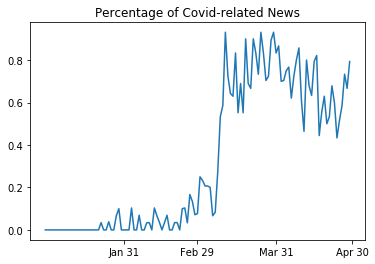

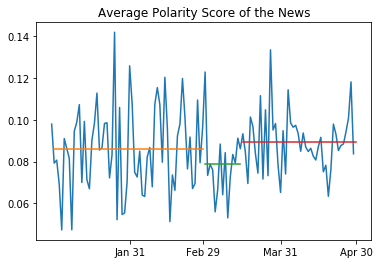

In [33]:
import matplotlib.pyplot as plt

plt.plot(date_list, perc)
plt.xticks([31, 60, 91, 121], ['Jan 31', 'Feb 29', 'Mar 31', 'Apr 30'])
plt.title("Percentage of Covid-related News")
plt.show()

av_score_before_feb_29 = np.mean(score[:60])
av_score_feb_29_mar_15 = np.mean(score[60:75])
av_score_after_mar_15 = np.mean(score[75:])

plt.plot(date_list, score)
plt.xticks([31, 60, 91, 121], ['Jan 31', 'Feb 29', 'Mar 31', 'Apr 30'])
plt.plot([1,60], [av_score_before_feb_29, av_score_before_feb_29])
plt.plot([61,75], [av_score_feb_29_mar_15, av_score_feb_29_mar_15])
plt.plot([76,121], [av_score_after_mar_15, av_score_after_mar_15])
plt.title("Average Polarity Score of the News")
plt.show()